In [163]:
# 引入常用库
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import datetime as dt
import itertools # 迭代器工具
import talib # 技术分析
import math
# 画图
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
from pylab import * 
import matplotlib
# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('ggplot')
# 忽略报错
import warnings
warnings.filterwarnings("ignore")

In [137]:
def cal_statistics(df):
    # 净值序列
    df['net_asset_pct_chg'] = df.net_asset_value.pct_change(1).fillna(0)

    # 总收益率和年化收益率
    total_ret = df['net_asset_value'].iloc[-1]-1
    annual_ret = total_ret**(1/(df.shape[0]/252))-1
    total_ret = total_ret*100
    annual_ret = annual_ret*100

    # 夏普比率
    sharp_ratio = df['net_asset_pct_chg'].mean() * math.sqrt(252)/df['net_asset_pct_chg'].std()

    # 回撤
    df['high_level'] = df['net_asset_value'].rolling(min_periods = 1, window = len(df),center = False).max()
    df['draw_down'] = df['net_asset_value'] - df['high_level']
    df['draw_down_pct'] = df['draw_down'] / df['high_level'] * 100
    max_draw_down = df['draw_down'].min()
    max_draw_down_pct = df['draw_down_pct'].min()

    # 持仓总天数
    hold_days = df['position'].sum()

    # 交易次数
    trade_count = df[df['flag']!=0].shape[0]/2

    # 平均持仓天数
    avg_hold_days = int(hold_days/trade_count)

    # 获利天数
    profit_days = df[df['net_asset_pct_chg']>0].shape[0]
    # 亏损天数
    loss_days = df[df['net_asset_pct_chg']<0].shape[0]

    # 胜率（按天）
    winrate_day = profit_days/(profit_days+loss_days)*100
    # 平均盈利率（按天）
    avg_profit_rate_day = df[df['net_asset_pct_chg']>0]['net_asset_pct_chg'].mean()*100
    # 平均亏损率（按天）
    avg_loss_rate_day = df[df['net_asset_pct_chg']<0]['net_asset_pct_chg'].mean()*100
    # 平均盈亏比（按天）
    avg_pl_ratio_day = avg_profit_rate_day/ abs(avg_loss_rate_day)

    # 每次交易情况
    buy_trades = df[df['flag']==1].reset_index()
    sell_trades = df[df['flag']==-1].reset_index()
    result_trade = {
        'buy':buy_trades['close'],
        'sell':sell_trades['close'],
        'pct_chg':(sell_trades['close'] - buy_trades['close'])/buy_trades['close']
    }
    result_trade = pd.DataFrame(result_trade)

    # 盈利次数
    profit_trades = result_trade[result_trade['pct_chg']>0].shape[0]
    # 亏损次数
    loss_trades = result_trade[result_trade['pct_chg']<0].shape[0]
    # 单次最大盈利
    max_profit_trade = result_trade['pct_chg'].max()*100
    # 单次最大亏损
    max_loss_trade = result_trade['pct_chg'].min()*100
    # 胜率（按次）
    winrate_trade = profit_trades/(profit_trades+loss_trades)*100
    # 平均盈利率（按次）
    avg_profit_rate_trade = result_trade[result_trade['pct_chg']>0]['pct_chg'].mean()*100
    # 平均亏损率（按次）
    avg_loss_rate_trade = result_trade[result_trade['pct_chg']<0]['pct_chg'].mean()*100
    # 平均盈亏比（按次）
    avg_pl_ratio_trade = avg_profit_rate_trade/ abs(avg_loss_rate_trade)

    statistics_result = {
        'net_asset_value':df['net_asset_value'].iloc[-1],#最终净值
        'total_return':total_ret,#收益率
        'annual_return':annual_ret,#年化收益率
        'sharp_ratio':sharp_ratio,#夏普比率
        'max_draw_percent':max_draw_down_pct,#最大回撤
        'hold_days':hold_days,#持仓天数
        'trade_count':trade_count,#交易次数
        'avg_hold_days':avg_hold_days,#平均持仓天数
        'profit_days':profit_days,#盈利天数
        'loss_days':loss_days,#亏损天数
        'winrate_by_day':winrate_day,#胜率（按天）
        'avg_profit_rate_day':avg_profit_rate_day,#平均盈利率（按天）
        'avg_loss_rate_day':avg_loss_rate_day,#平均亏损率（按天）
        'avg_profit_loss_ratio_day':avg_pl_ratio_day,#平均盈亏比（按天）
        'profit_trades':profit_trades,#盈利次数
        'loss_trades':loss_trades,#亏损次数
        'max_profit_trade':max_profit_trade,#单次最大盈利
        'max_loss_trade':max_loss_trade,#单次最大亏损
        'winrate_by_trade':winrate_trade,#胜率（按次）
        'avg_profit_rate_trade':avg_profit_rate_trade,#平均盈利率（按次）
        'avg_loss_rate_trade':avg_loss_rate_trade,#平均亏损率（按次）
        'avg_profit_loss_ratio_trade':avg_pl_ratio_trade#平均盈亏比（按次）
    }

    return statistics_result


In [138]:
# 策略
def stratege(df1:pd.DataFrame,colname:str,buy_threshold:int,sell_threshold:int):
    # 初始资金
    money = 1000000
    # 买入股数
    num = 0
    # 手续费
    cost = 0.0001
    # 是否持有（0:未持有）
    position = 0

    for i in range(len(df1.index)-1):
        if df1[colname].iloc[i] > buy_threshold and position == 0:
            df1['flag'].iloc[i] = 1 #开仓
            df1['position'].iloc[i+1] = 1 #下一个仓位不空
            position = 1
            # 账户余额变化
            buy_price = df1['close'].iloc[i]
            # buy_time = df1['date'].iloc[i]
            num = (money//buy_price//100)*100
            money -= num*buy_price*(1+cost)
        elif df1[colname].iloc[i] < sell_threshold and position == 1:
            df1['flag'].iloc[i] = -1 #平仓
            df1['position'].iloc[i+1] = 0 #空仓
            position = 0
            # 账户余额变化
            sell_price = df1['close'].iloc[i]
            # sell_time = df1['date'].iloc[i]
            num = (money//sell_price//100)*100
            money += num*sell_price*(1-cost)
        elif position == 1 and df1['close'].iloc[i] < 0.8*buy_price: #止损
            df1['flag'].iloc[i] = -1 #平仓
            df1['position'].iloc[i+1] = 0 #空仓
            position = 0
            # 账户余额变化
            sell_price = df1['close'].iloc[i]
            # sell_time = df1['date'].iloc[i]
            num = (money//sell_price//100)*100
            money += num*sell_price*(1-cost)
        else:
            df1['position'].iloc[i+1] = df1['position'].iloc[i]
        
        if position == 1:
            df1['asset_value'].iloc[i] = money + df1['close'].iloc[i]*num
        elif position == 0:
            df1['asset_value'].iloc[i] = money

    # 计算净值序列
    df1['net_asset_value'] = (1+df1.close.pct_change(1).fillna(0)*df1.position).cumprod()
    df1['asset_value'].iloc[-1] = df1['asset_value'].iloc[-2]
    return df1

In [139]:
# 11111斜率方法：用连续N日的最高价与最低价的线性回归模型的斜率来量化支撑位与阻力位的相对强度（RSRS）

# 构建斜率指标：
# Step 1: 取前 N 日(N=18)的最高价序列与最低价序列。
# Step 2: 将两列数据进行 OLS 线性回归。
# Step 3: 将拟合后的 beta 值作为当日 RSRS 斜率指标值。

# 策略：
# 1. 计算 RSRS 斜率。
# 2. 如果斜率大于 1，则买入持有。
# 3. 果斜率小于 0.8，则卖出手中持股平仓。

def cal_beta(df,n):

    nbeta = []
    trade_days = len(df.index)
    df['position'] = 0
    df['flag'] = 0
    position = 0

    for i in range(trade_days):
        if i < (n-1):
            continue
        else:
            x = df['low'].iloc[i-n+1:i+1]
            x = sm.add_constant(x)
            y = df['high'].iloc[i-n+1:i+1]
            model = sm.OLS(y,x)
            res = model.fit()
            beta = round(res.params[1],2)
            nbeta.append(beta)
    df1 = df.iloc[n-1:]
    df1['beta'] = nbeta
    df1['asset_value'] = 0

    # 策略：
    df1 = stratege(df1,'beta',1,0.8)

    return df1


In [140]:
# 22222斜率方法的优化——斜率标准分
# 需要参考斜率指标在历史上的均值和标准差以选择合适的开仓、平仓阈值。
# 根据斜率在最近一定周期内（600个交易日）的标准分确定阈值可以更加灵活地适应近期的整体市场基本状态。

# 构建斜率标准分指标：
# 1. 取前 M 日（600日）的斜率时间序列。
# 2. 以此样本计算当日斜率的标准分。
# 3. 将计算得到的标准分 z 作为当日 RSRS 标准分指标值。

# 策略：
# 1.根据斜率计算标准分（参数 N=18,M=600）。
# 2.如果标准分大于 S（参数 S=0.7），则买入持有。
# 3.如果标准分小于-S，则卖出平仓。

def cal_std_beta(df,n,m):
    
    df1 = cal_beta(df,n)
    df1['position']=0
    df1['flag']=0
    df1['asset_value'] = 0
    position = 0
    
    df1['std_beta'] = (df1['beta'] - df1['beta'].rolling(m).mean())/df1['beta'].rolling(m).std()
    df1.dropna(how = 'any',inplace = True)
    
    # 策略
    df1 = stratege(df1,'std_beta',0.7,-0.7)
    return df1

In [141]:
# 33333修正标准分：考虑到线性拟合的程度(R2)
# 在线性回归中，R 平方值（决定系数）可以理解成线性拟合效果的程度。
# 修正标准分=标准分*R 平方值（决定系数）

# 策略：
# 1. 计算修正标准分（N=16,M=300）。
# 2. 如果修正标准分大于 S（S=0.7），则买入持有。
# 3. 如果修正标准分小于-S，则卖出平仓。

def cal_stdbeta_v2(df,n,m):
    nbeta = []
    R2 = []
    trade_days = len(df.index)
    df['position'] = 0
    df['flag'] = 0
    df['asset_value'] = 0
    position = 0

    for i in range(trade_days):
        if i < (n-1):
            continue
        else:
            x = df['low'].iloc[i-n+1:i+1]
            x = sm.add_constant(x)
            y = df['high'].iloc[i-n+1:i+1]
            model = sm.OLS(y,x)
            res = model.fit()
            beta = round(res.params[1],2)
            nbeta.append(beta)
            R2.append(res.rsquared)

    df1 = df.iloc[n-1:]
    df1['beta'] = nbeta
    df1['R2'] = R2
    df1['std_beta'] = (df1['beta'] - df1['beta'].rolling(m).mean())/df1['beta'].rolling(m).std()
    df1.dropna(how = 'any',inplace = True)
    df1['std_beta'] = df1['std_beta']*df1['R2']

    # 策略
    df1 = stratege(df1,'std_beta',0.7,-0.7)
    return df1

In [142]:
# 44444右偏标准分
# 右偏标准分=修正标准分*斜率

# 策略
# 1. 计算右偏标准分（N=16,M=300）。
# 2. 如果右偏标准分大于 S（S=0.7），则买入持有。
# 3. 如果右偏标准分小于-S，则卖出平仓。

def cal_right_stdbeta(df,n,m):
    df1 = cal_stdbeta_v2(df,n,m)
    df1['position']=0
    df1['flag']=0
    df1['asset_value'] = 0
    position=0
    
    df1['right_std_beta'] = df1['std_beta']*df1['beta']
    
    # 策略
    df1 = stratege(df1,'right_std_beta',0.7,-0.7)
    return df1

In [143]:
# 55555
# 期望在保证收益的同时，尽可能降低熊市错误开仓的几率。
# 先判断市场状态是处在上升还是下跌趋势，再结合RSRS构建买入、卖出策略。
# 使用当日 20 日均线值与 3 日前 20 日均线值的相对大小来判断近期市场状态。

# 策略：
# 1. 计算 RSRS 标准分指标买卖信号。
# 2. 如果指标发出买入信号，同时满足前一日 MA(20)的值大于前三日MA(20)的值，则买入。
# 3. 如果指标发出卖出信号，则卖出手中持股

def cal_ma_beta(df,n,m):
    df1 = cal_std_beta(df,n,m)
    df1['position']=0
    df1['flag']=0
    df1['asset_value'] = 0
    position = 0

    df1['ma'] = df1.close.rolling(20).mean()
    df1['ma'] = np.where(df1['ma'].shift(1) > df1['ma'].shift(3),1,0)
    df1.dropna(how = 'any',axis = 0,inplace = True)

    money = 1000000
    num = 0
    cost = 0.0001

    for i in range(len(df1.index)-1):
        if df1['std_beta'].iloc[i] > 0.7 and position == 0 and df1['ma'].iloc[i]==1:
            df1['flag'].iloc[i] = 1 #开仓
            df1['position'].iloc[i+1] = 1 #下一个仓位不空
            position = 1
            # 账户余额变化
            buy_price = df1['close'].iloc[i]
            # buy_time = df1['date'].iloc[i]
            num = (money//buy_price//100)*100
            money -= num*buy_price*(1+cost)
        elif df1['std_beta'].iloc[i] < -0.7 and position == 1:
            df1['flag'].iloc[i] = -1 #平仓
            df1['position'].iloc[i+1] = 0 #空仓
            position = 0
            # 账户余额变化
            sell_price = df1['close'].iloc[i]
            # sell_time = df1['date'].iloc[i]
            num = (money//sell_price//100)*100
            money += num*sell_price*(1-cost)
        elif position == 1 and df1['close'].iloc[i] < 0.8*buy_price: #止损
            df1['flag'].iloc[i] = -1 #平仓
            df1['position'].iloc[i+1] = 0 #空仓
            position = 0
            # 账户余额变化
            sell_price = df1['close'].iloc[i]
            # sell_time = df1['date'].iloc[i]
            num = (money//sell_price//100)*100
            money += num*sell_price*(1-cost)
        else:
            df1['position'].iloc[i+1] = df1['position'].iloc[i]
        
        if position == 1:
            df1['asset_value'].iloc[i] = money + df1['close'].iloc[i]*num
        elif position == 0:
            df1['asset_value'].iloc[i] = money

    # 计算净值序列
    df1['net_asset_value'] = (1+df1.close.pct_change(1).fillna(0)*df1.position).cumprod()
    df1['asset_value'].iloc[-1] = df1['asset_value'].iloc[-2]
    return df1


In [144]:
# 66666基于 RSRS 指标与交易量相关性的优化
# 策略：
# 1. 计算 RSRS 标准分指标买卖信号。
# 2. 如果指标发出买入信号，同时满足前 10 日交易量与修正标准分之间的相关性为正，则买入。
# 3. 如果指标发出卖出信号，则卖出手中持股。


def cal_vol_beta(df,n,m):
    df1 = cal_std_beta(df,n,m)
    df1['position'] = 0
    df1['flag'] = 0
    df1['asset_value'] = 0
    position = 0

    money = 1000000
    num = 0
    cost = 0.0001

    for i in range(10,len(df1.index)-1):
        vol = df1['volume'].iloc[i-10:i]
        beta = df1['std_beta'].iloc[i-10:i]
        corr_vol_beta = vol.corr(beta,method = 'pearson')

        if df1['std_beta'].iloc[i] > 0.7 and position == 0 and corr_vol_beta>0:
            df1['flag'].iloc[i] = 1 #开仓
            df1['position'].iloc[i+1] = 1 #下一个仓位不空
            position = 1
            # 账户余额变化
            buy_price = df1['close'].iloc[i]
            # buy_time = df1['date'].iloc[i]
            num = (money//buy_price//100)*100
            money -= num*buy_price*(1+cost)
        elif df1['std_beta'].iloc[i] < -0.7 and position == 1:
            df1['flag'].iloc[i] = -1 #平仓
            df1['position'].iloc[i+1] = 0 #空仓
            position = 0
            # 账户余额变化
            sell_price = df1['close'].iloc[i]
            # sell_time = df1['date'].iloc[i]
            num = (money//sell_price//100)*100
            money += num*sell_price*(1-cost)
        elif position == 1 and df1['close'].iloc[i] < 0.8*buy_price: #止损
            df1['flag'].iloc[i] = -1 #平仓
            df1['position'].iloc[i+1] = 0 #空仓
            position = 0
            # 账户余额变化
            sell_price = df1['close'].iloc[i]
            # sell_time = df1['date'].iloc[i]
            num = (money//sell_price//100)*100
            money += num*sell_price*(1-cost)
        else:
            df1['position'].iloc[i+1] = df1['position'].iloc[i]
        
        if position == 1:
            df1['asset_value'].iloc[i] = money + df1['close'].iloc[i]*num
        elif position == 0:
            df1['asset_value'].iloc[i] = money

    # 计算净值序列
    df1['net_asset_value'] = (1+df1.close.pct_change(1).fillna(0)*df1.position).cumprod()
    df1['asset_value'].iloc[-1] = df1['asset_value'].iloc[-2]
    return df1


In [145]:
# 数据
stock = pd.read_csv('stock_hs300.csv')
stock = stock.iloc[:,[2,3,4,5,6,8]]
stock.rename(columns = {
    "日期":'date',
    "开盘价(元)":'open',
    "最高价(元)":'high',
    "最低价(元)":'low',
    "收盘价(元)":'close',
    "成交量(股)":'volume'},inplace = True)
stock['date'] = pd.to_datetime(stock['date'])
stock.set_index('date',inplace = True)
stock.head()

,open,high,low,close,volume
date,,,,,
2005-01-04,994.77,994.77,980.66,982.79,741286900
2005-01-05,981.58,997.32,979.88,992.56,711910900
2005-01-06,993.33,993.79,980.33,983.17,628802900
2005-01-07,983.05,995.71,979.81,983.96,729869400
2005-01-10,983.76,993.96,979.79,993.88,579169800


In [146]:
n = 18
m = 600
df_beta = cal_beta(stock,n)
df_std_beta = cal_std_beta(stock,n,m)
df_vol_beta = cal_vol_beta(stock,n,m)
df_ma_beta = cal_ma_beta(stock,n,m)
df_right_beta = cal_right_stdbeta(stock,n,m)
df_std_beta_v2 = cal_stdbeta_v2(stock,n,m)


In [152]:
# statistics
statistic_beta = pd.DataFrame(cal_statistics(df_beta),index=['斜率方法']).T
statistic_std_beta = pd.DataFrame(cal_statistics(df_std_beta),index=['标准分']).T
statistic_std_beta_v2 = pd.DataFrame(cal_statistics(df_std_beta_v2),index=['修正标准分']).T
statistic_right_beta = pd.DataFrame(cal_statistics(df_right_beta),index=['右偏标准分']).T
statistic_ma_beta = pd.DataFrame(cal_statistics(df_ma_beta),index=['基于RSRS指标和市场状态的优化']).T
statistic_vol_beta = pd.DataFrame(cal_statistics(df_vol_beta),index=['基于RSRS指标与交易量相关性的优化']).T

In [153]:
statistic_beta1 = pd.concat(
    [statistic_beta,
    statistic_std_beta,
    statistic_std_beta_v2,
    statistic_right_beta,
    statistic_ma_beta,
    statistic_vol_beta],axis = 1)
statistic_beta1

,斜率方法,标准分,修正标准分,右偏标准分,基于RSRS指标和市场状态的优化,基于RSRS指标与交易量相关性的优化
net_asset_value,12.835437,6.363142,5.353853,4.933239,5.420728,6.738520
total_return,1183.543749,536.314206,435.385279,393.323873,442.072841,573.852041
annual_return,16.076851,12.557205,10.916495,10.125656,11.035638,13.094787
sharp_ratio,0.962274,0.866404,0.791038,0.722918,0.997689,1.069656
max_draw_percent,-53.421338,-49.581874,-53.421338,-53.421338,-19.513977,-19.152590
hold_days,1859.000000,1650.000000,1647.000000,1866.000000,1121.000000,1239.000000
trade_count,61.000000,62.000000,51.000000,45.000000,43.000000,47.000000
avg_hold_days,30.000000,26.000000,32.000000,41.000000,26.000000,26.000000
profit_days,1029.000000,888.000000,887.000000,1001.000000,623.000000,688.000000
loss_days,830.000000,762.000000,760.000000,865.000000,498.000000,551.000000


In [155]:
# 统计画图
def stat_depict_plot(df, col,title):
    
    df = df[~df[col].isna()].copy()
    
    avgRet = np.mean(df[col])
    medianRet = np.median(df[col])
    stdRet = np.std(df[col])
    skewRet = st.skew(df[col])
    kurtRet = st.kurtosis(df[col])
    
    plt.style.use('ggplot')
    # 画日对数收益率分布直方图
    fig = plt.figure(figsize=(18, 9))
    plt.suptitle(title)
    v = df[col]
    x = np.linspace(avgRet - 3*stdRet, avgRet + 3*stdRet, 100)
    y = st.norm.pdf(x, avgRet, stdRet)
    kde = st.gaussian_kde(v)

    # plot the histogram
    plt.subplot(121)
    plt.hist(v, 50, weights=np.ones(len(v))/len(v), alpha=0.4)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.axvline(x=avgRet - stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='-1 Standard Deviation')
    plt.axvline(x=avgRet + stdRet, color='blue', linestyle='--',
                linewidth=0.8, label='1 Standard Deviation')
    plt.ylabel('Percentage', fontsize=10)
    plt.legend(fontsize=12)

    # plot the kde and normal fit
    plt.subplot(122)
    plt.plot(x, kde(x), label='Kernel Density Estimation')
    plt.plot(x, y, color='black', linewidth=1, label='Normal Fit')
    plt.ylabel('Probability', fontsize=10)
    plt.axvline(x=avgRet, color='red', linestyle='--',
                linewidth=0.8, label='Mean Count')
    plt.legend(fontsize=12)
    return plt.show()

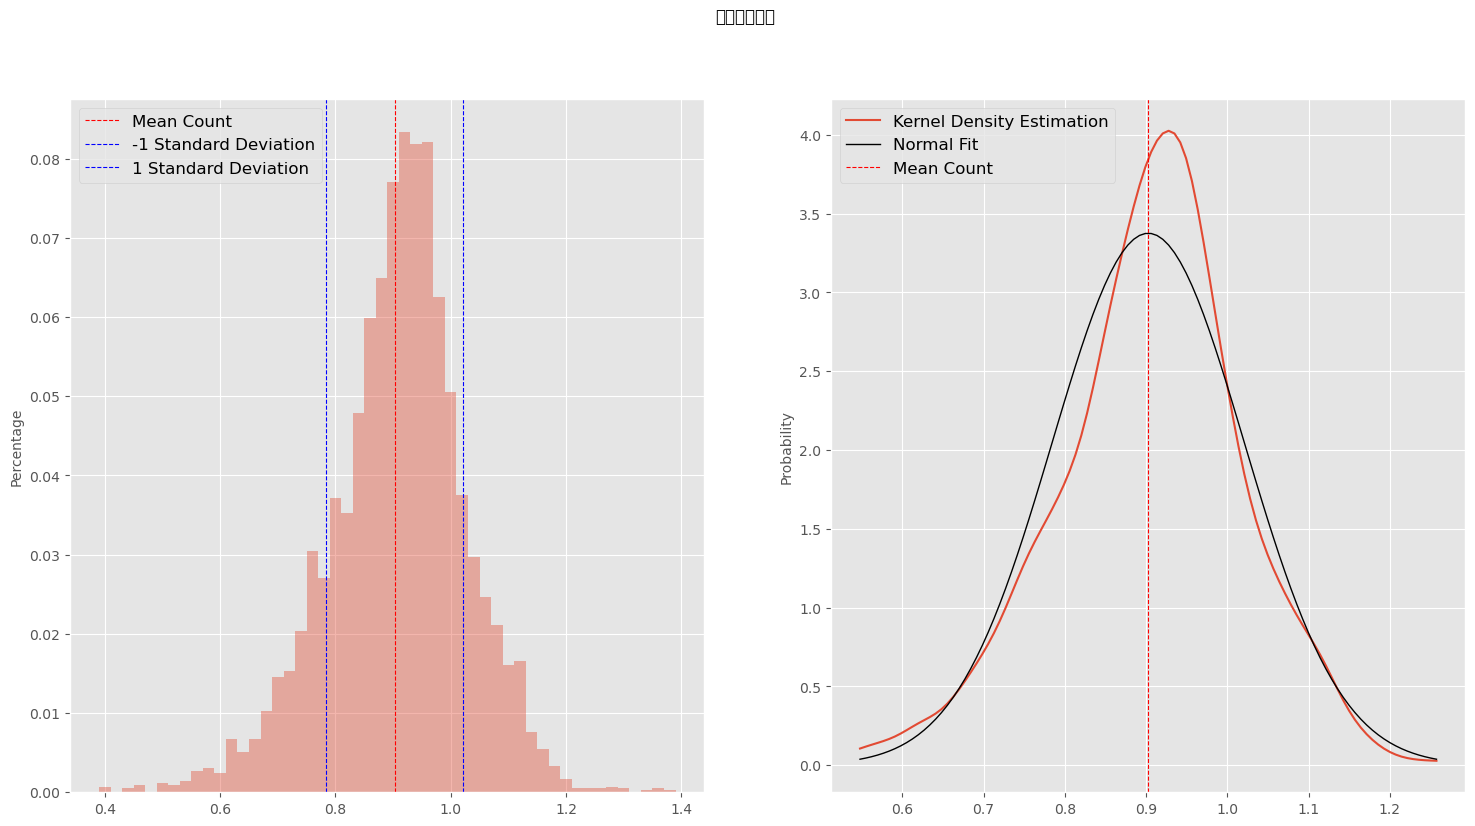

In [167]:
# 查看斜率分布
stat_depict_plot(df_beta,'beta','斜率数据分布')

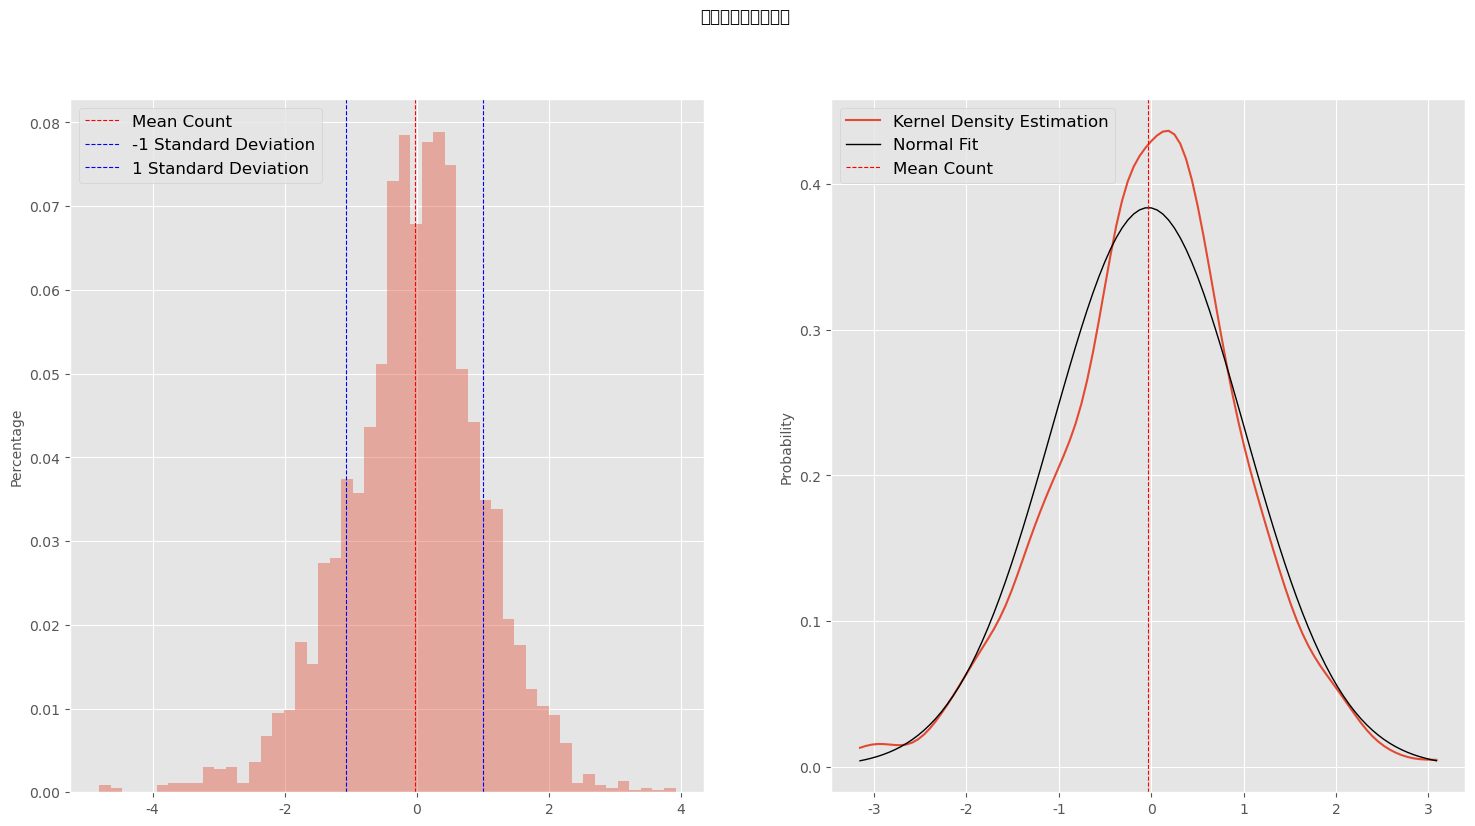

In [169]:
# 查看标准分斜率分布
stat_depict_plot(df_std_beta,'std_beta','标准分斜率数据分布')

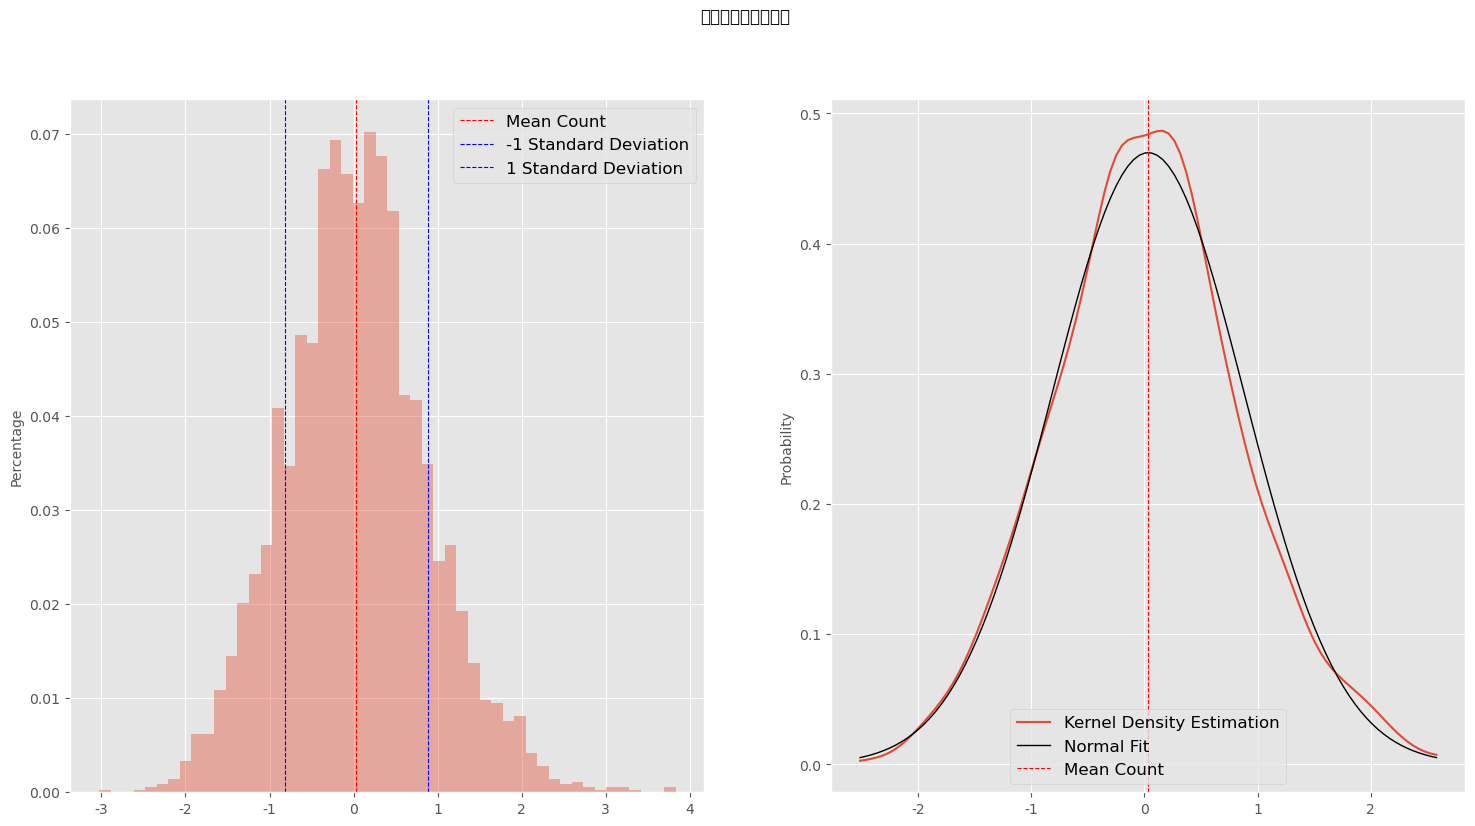

In [170]:
# 查看修正标准分斜率分布
stat_depict_plot(df_std_beta_v2,'std_beta','修正标准分斜率数据分布')

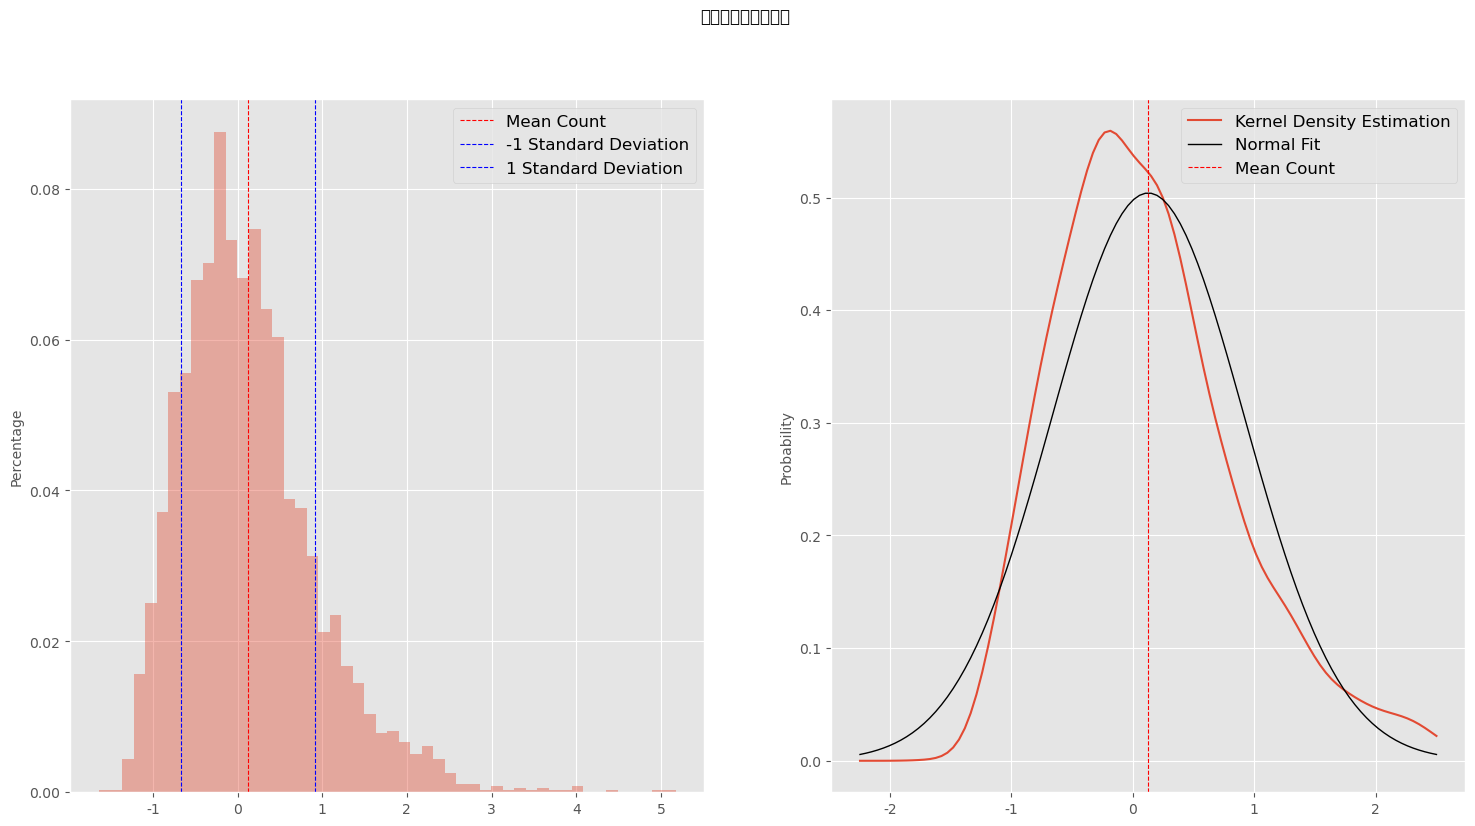

In [172]:
# 查看右偏标准分斜率分布
stat_depict_plot(df_right_beta,'right_std_beta','右偏标准分斜率数据分布')

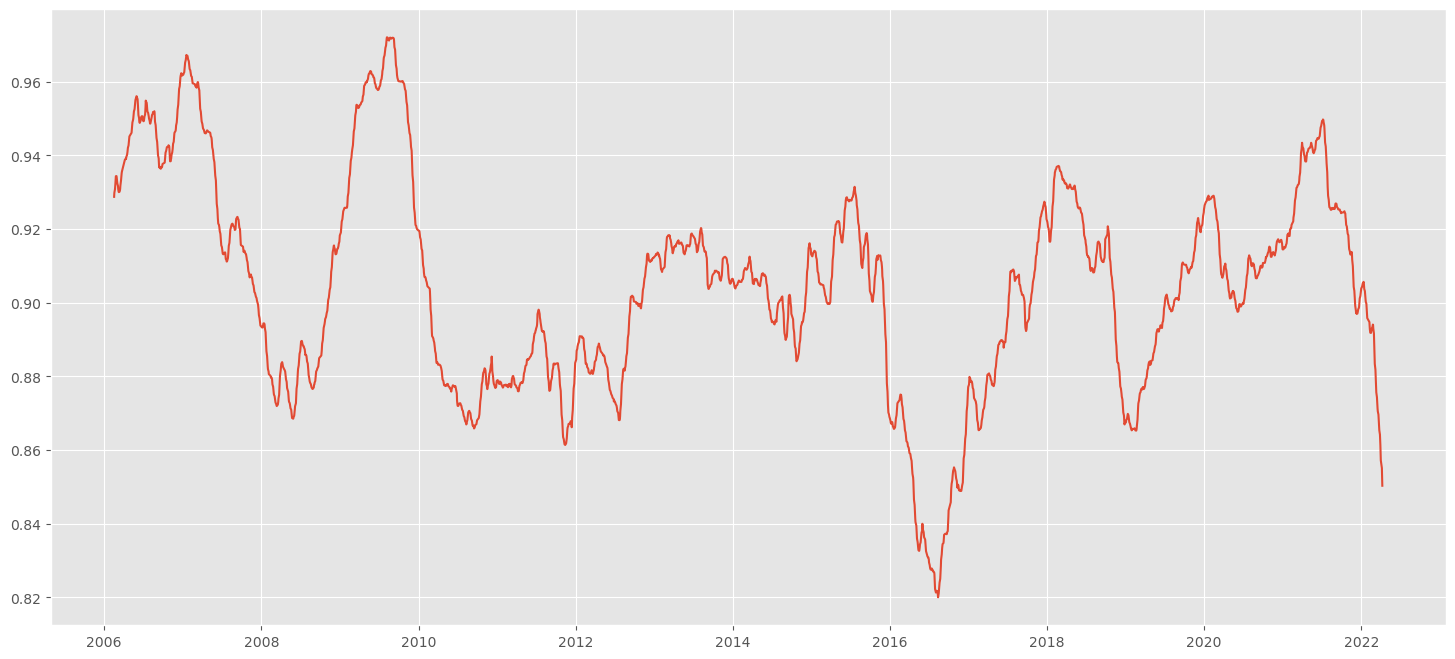

In [165]:
# 各期斜率情况
plt.figure(figsize=(18,8))
plt.plot(df_beta['beta'].rolling(250).mean())

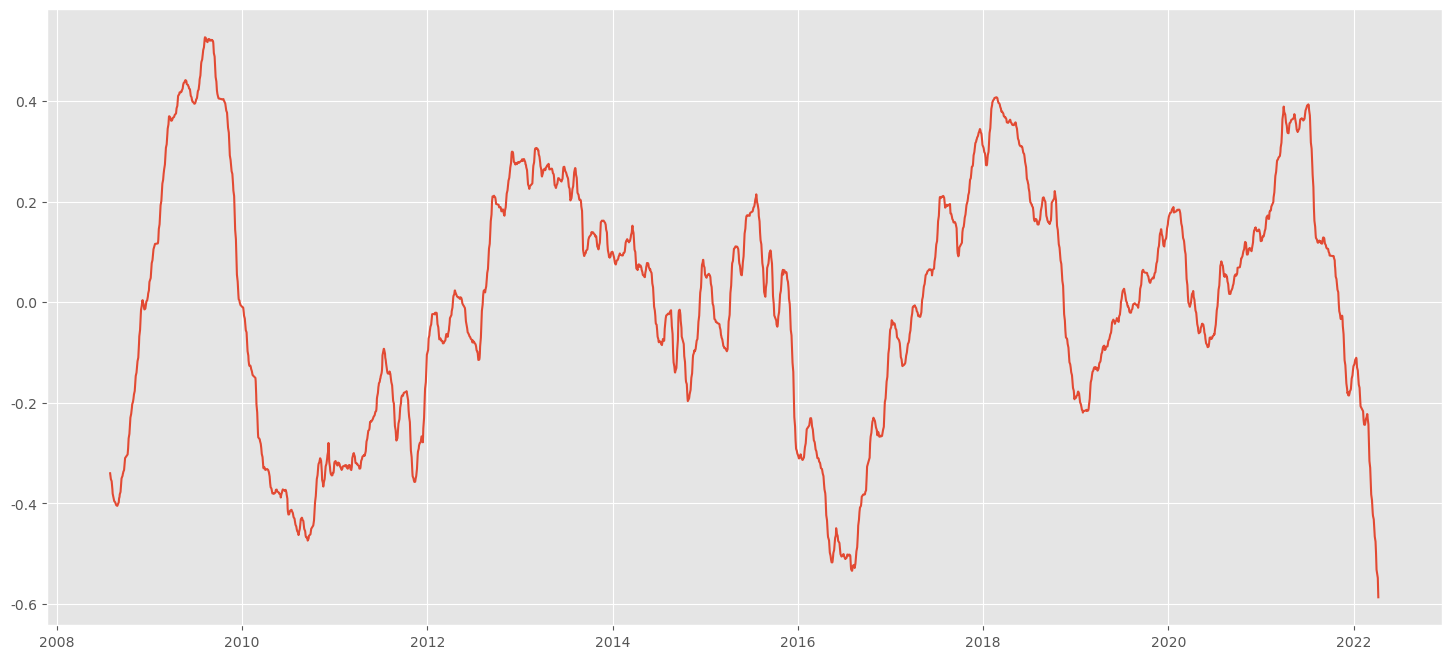

In [173]:
# 各期标准化斜率情况
plt.figure(figsize=(18,8))
plt.plot(df_std_beta['std_beta'].rolling(250).mean())

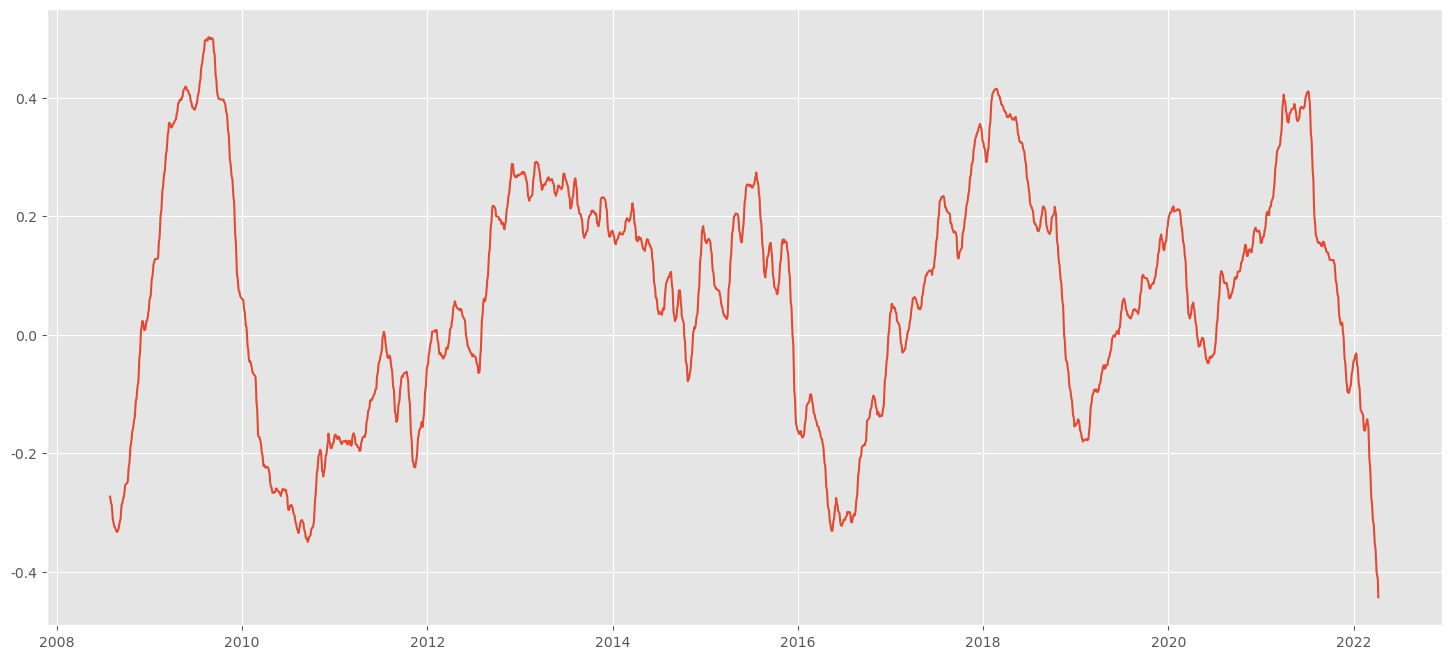

In [174]:
# 各期修正标准分斜率情况
plt.figure(figsize=(18,8))
plt.plot(df_std_beta_v2['std_beta'].rolling(250).mean())

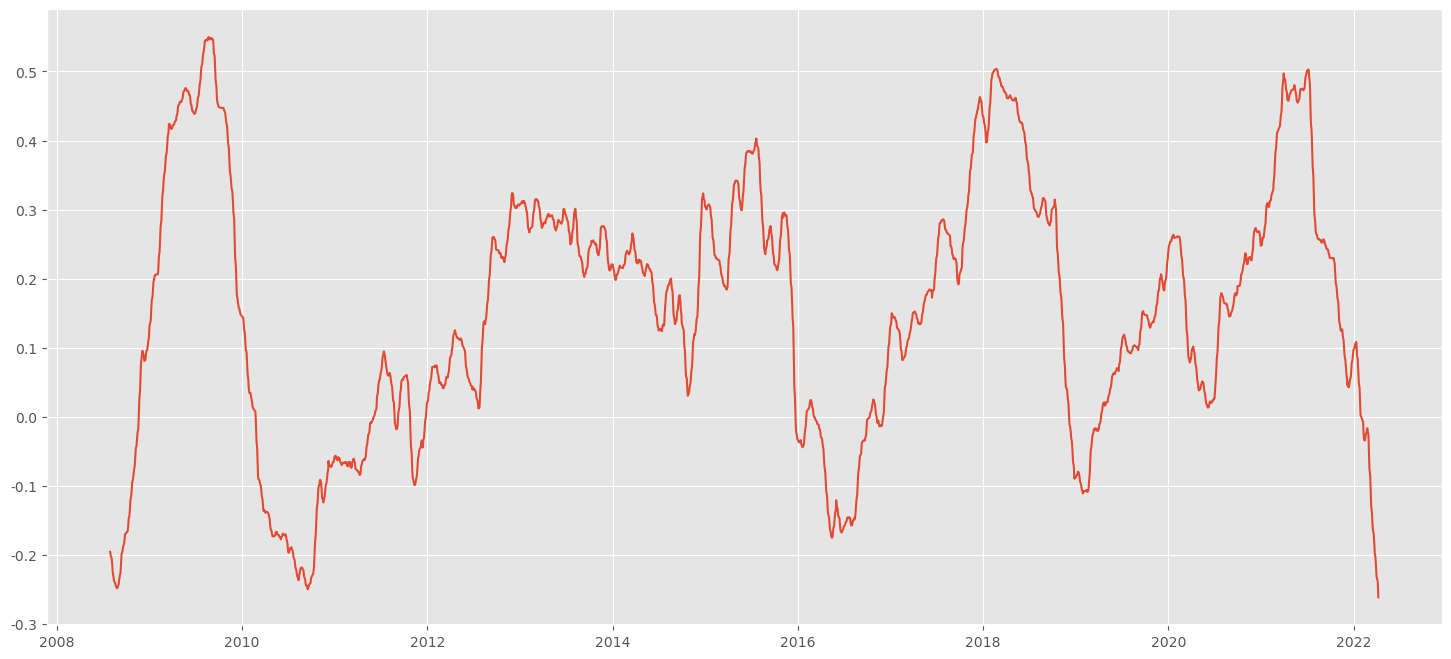

In [177]:
# 各期右偏标准分斜率情况
plt.figure(figsize=(18,8))
plt.plot(df_right_beta['right_std_beta'].rolling(250).mean())